In [1]:
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Reading in the data
X = pd.read_csv('../input/carsforsale/cars_raw.csv')
X_test_full = pd.read_csv('../input/carsforsale/cars_raw.csv')

#Removing unnecessary character's and converting the Price coloumn to float
X["Price"] = X["Price"].str.replace(',', '')
X["Price"] = X["Price"].str.replace('$', '')
X["Price"] = X["Price"].apply(lambda x: re.sub(r"\D","",x))
X["Price"] = pd.to_numeric(X["Price"])

# Drop data
X.dropna(axis=0, subset=['Price'], inplace=True)

target = X.Price

#Dropping columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()]                                  
candidate_train_predictors = X.drop(['Year','Price'] + cols_with_missing, axis=1)
candidate_test_predictors = X_test_full.drop(['Year'] + cols_with_missing, axis=1)

#Selecting coloumns with a low cardinality 
low_cardinality_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].nunique() < 10 and
                                candidate_train_predictors[cname].dtype == "object"]
numeric_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols
train_predictors = candidate_train_predictors[my_cols]
test_predictors = candidate_test_predictors[my_cols]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  from ipykernel import kernelapp as app


In [2]:
#Checking the dtypes
train_predictors.dtypes
#Checking information on the dataset
print(X.info())
print(target.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9374 entries, 0 to 9378
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   9374 non-null   int64  
 1   Make                   9374 non-null   object 
 2   Model                  9374 non-null   object 
 3   Used/New               9374 non-null   object 
 4   Price                  9374 non-null   float64
 5   ConsumerRating         9374 non-null   float64
 6   ConsumerReviews        9374 non-null   int64  
 7   SellerType             9374 non-null   object 
 8   SellerName             9374 non-null   object 
 9   SellerRating           9374 non-null   float64
 10  SellerReviews          9374 non-null   int64  
 11  StreetName             9374 non-null   object 
 12  State                  9374 non-null   object 
 13  Zipcode                9374 non-null   object 
 14  DealType               9152 non-null   object 
 15  Comf

In [3]:
#One-hot encoding
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)

In [4]:
# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['Price'], inplace=True)
y = X.Price 
X.drop(['Price'], axis=1, inplace=True)

#Validating and training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

#Selecting categorical columns with low cardinality
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Selecting numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keeping only the selected columns
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

#One Hot Encoding
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [5]:
# Defining the model
model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Fiting the model
model.fit(X_train, y_train)

#Getting the Predictions
predictions = model.predict(X_valid)
print("Price Predictions for Cars: ", predictions )

#Calculating Mean Absolute Error
mae = mean_absolute_error(predictions, y_valid)
print("Mean Absolute Error:" , mae) 

Price Predictions for Cars:  [30841.01  26794.191 34073.105 ... 31042.754 41522.605 35578.875]
Mean Absolute Error: 3335.7001911458333


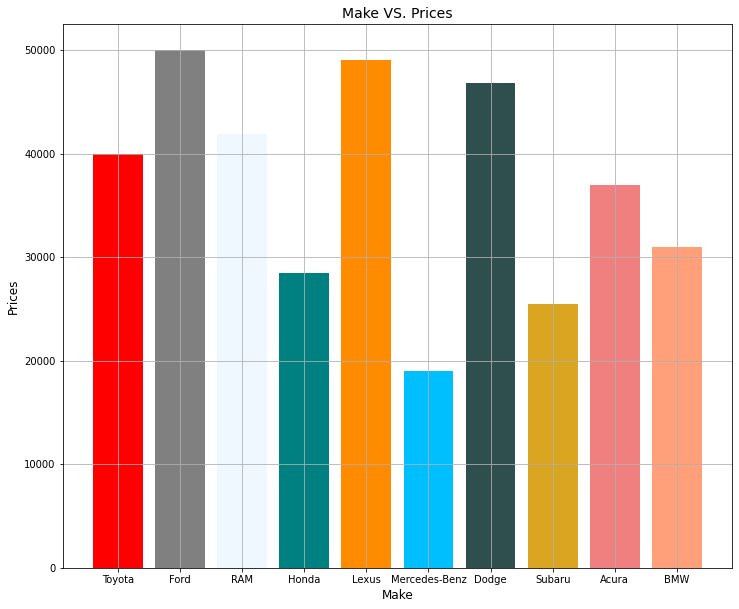

In [6]:
#Read Data
df = pd.read_csv('../input/carsforsale/cars_raw.csv')

#Set Dimensions
dimensions = plt.figure()
dimensions.set_figwidth(12)
dimensions.set_figheight(10)

#Selected 10 random car make's
Data = {'Make': ['Toyota','Ford','RAM','Honda','Lexus','Mercedes-Benz','Dodge','Subaru','Acura','BMW'],
        'Price': [39998,49985,41860,28500,49000,18985,46773,25500,37000,30995]
       }
df = pd.DataFrame(Data,columns=['Make','Price'])

#Setting colors
colors = ['red','grey','aliceblue','teal','darkorange','deepskyblue',
          'darkslategray','goldenrod','lightcoral','lightsalmon']
#Building Bar Graph
plt.bar(df['Make'], df['Price'], color= colors)
plt.title('Make VS. Prices', fontsize=14)
plt.xlabel('Make', fontsize=12)
plt.ylabel('Prices', fontsize=12)  
plt.grid(True)
plt.show()